#My hometown seen by Sentinel-2

In this notebook I'm going to investigate my hometown area seen from the "eyes" of Sentinel-2 satellites, part of the ESA Copernicus constellation.

Instead of accessing data through one of the many portals available in the web, I will request data through APIs (Sentinel Hub in the specific). 

In order to retrieve meaningful data from optical bands, request will be calibrated to get the first least cloud-free image from the chosen date.

Examples with some of the most common indices will be shown in two ways: first getting data from a boundig box area around my hometown, second cropping the image for its administrative area bounding. 


 


##Imports

In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade sentinelhub

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import SHConfig, MimeType, CRS, BBox, Geometry, DownloadRequest,
from sentinelhub import SentinelHubRequest, SentinelHubDownloadClient, DataCollection,  bbox_to_dimensions 



##Settings

###Sentinel Hub account configuration

Passing account credentials, previously saved as environment variables, to Sentinel Hub API 

In [ ]:
## get credentials from environment


import os

config = SHConfig()

config.instance_id = os.environmet.get("INSTANCE_ID")
config.sh_client_id = os.environmet.get("SH_CLIENT_ID")
config.sh_client_secret = os.environmet.get("SH_CLIENT_SECRET")


config.save()


###Space and time

Define the desired area to be visualized and date of interest. 

####Area

In [ ]:
## setting area coordinates, obtained through bboxfinder.com
sacile_coords = [12.230530, 45.779017, 12.757874, 46.069420]
resolution = 60

## create BBox object
sacile_bbox = BBox(bbox=sacile_coords, crs=CRS.WGS84)
sacile_size = bbox_to_dimensions(sacile_bbox, resolution=resolution)
print(f"sacile_size: {sacile_size}")

print(f'Image shape at {resolution}m resolution: {sacile_size[0]} x {sacile_size[1]} pixels')

sacile_size: (698, 516)
Image shape at 60m resolution: 698 x 516 pixels


####Time


In [ ]:
## Setting timespan;

##instead of pointing at a particular date, it's better to request a period 
## long enough to consider the eventuality of cloud cover images: one month would do.

from datetime import date, timedelta 

today = date.today()
month_ago = today - timedelta(days = 30)

today_formatted = today.strftime("%Y-%m-%d")
month_ago_formatted = month_ago.strftime("%Y-%m-%d")

timespan = (month_ago_formatted, today_formatted)
print(f"Considered period: from {month_ago} to {today}")

Considered period: from 2021-04-28 to 2021-05-28


###Function to plot image

In [ ]:
import matplotlib.patches as mpatches


def plot_image(image, colors, index, factor=1.0, clip_range=None, **kwargs):
    """ Utility function for plotting RGB images."""

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        im = ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        im = ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    if colors is not None:
        patches = [ mpatches.Patch(color=colors[i]["code"], label=f"{index} {colors[i]['value']}") for i in range(len(colors)) ]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    


## Examples - Bounding Box

Extracting main indices from Sentinel-2 data such as NDVI and SAVI 



###1. True colors image

Get first available image in specified timespan

In [ ]:
## True color evalscript

evalscript_true_color = """
    //VERSION=3
    function setup() {return {
            input: [{
              bands: ["B02", "B03", "B04", ]
            }],
            output: {bands: 3}
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""


In [ ]:
## Running request

request_true_color= SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=sacile_bbox,
    size=sacile_size,
    config=config)

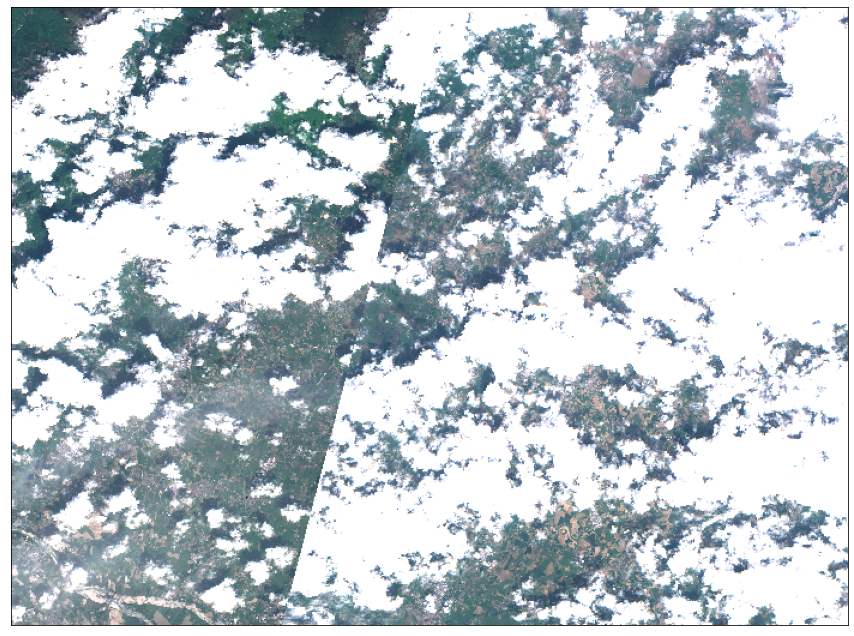

In [ ]:
## plot image

img = request_true_color.get_data()[0]
plot_image(img, colors=None, index=None, factor=3.5/255, clip_range=(0,1))

###2. Cloud free true colors  image

Get first least cloudy image from the defined date

In [ ]:
## request cloud free image

request_leastCC = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
            mosaicking_order="leastCC"
      )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=sacile_bbox,
    size=sacile_size,
    config=config
    )


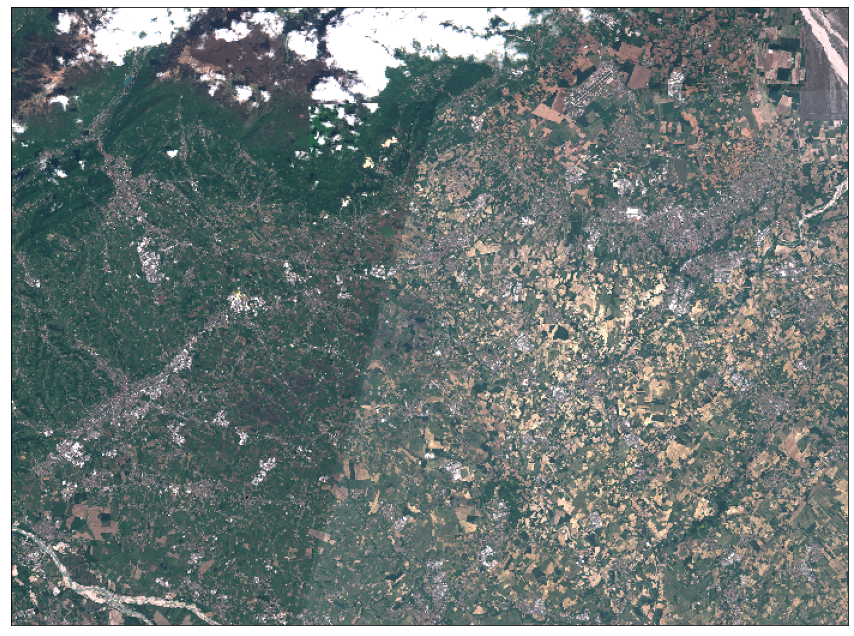

In [ ]:
## plot image

img_leastCC = request_leastCC.get_data()[0]
plot_image(img_leastCC, colors=None, index=None, factor=3.5/255, clip_range=(0,1))

###3. NDVI

NDVI, Normalized Difference Vegetation Index, it's commonly used to quantify green vegetation in a desired area. It represents the state of vegetation health based on how plants reflect light at certain wavelenghts. 
NDVI values range from -1 to 1, where:
- 0.2 to 0.4 represent grassland and shrub;
- 0.4 to 0.7 correspond to denser vegetation

In [ ]:
## NDVI evalscript

ndvi_colors = [{"value": "<0.2", "code": [1, 1, 1], "name": "white"},
               {"value": "<0.4", "code": [0, 1, 0], "name": "dark green"},
               {"value": "<0.7", "code": [0, 0.5, 0], "name": "black"},    
               ]



evalscript_ndvi = '''
//VERSION=3
function setup(){return{input: [{bands: ["B02", "B03", "B04", "B08" ]}], 
                        output: {id: "default", bands: 1,
                                  sampleType: SampleType.FLOAT32}}
                 }

function evaluatePixel(sample) {
	var NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
	
  if (NDVI < 0.2) {
		return [1,1,1] 
	}
	if (NDVI < 0.4) {
		return [0, 1, 0] 
	}
	
	if (NDVI > 0.7) {
		return [0, 0.5, 0]
    } 

}
'''



# return colorBlend( NDVI, [0, 0.5, 1], [[1,1,1], [0, 0.5, 0],  [0, 0, 0]])

In [ ]:
## NDVI evalscript - colorBlend

ndvi_colors = [{"value": "<0.2", "code": [1, 1, 1], "name": "white"},
               {"value": "<0.4", "code": [0, 0.5, 0], "name": "dark green"},
               {"value": "<0.7", "code": [0, 0, 0], "name": "black"},    
               ]

evalscript_ndvi = '''
//VERSION=3
function setup(){return{input: [{bands: ["B04", "B08" ]}], 
                        output: {id: "default", bands: 1,
                                  sampleType: SampleType.FLOAT32}}
                 }

function evaluatePixel(sample) {
	var NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
	return colorBlend( NDVI, [0, 0.5, 1], [[1,1,1], [0, 0.5, 0],  [0, 0, 0]])
}
'''



In [ ]:
## request cloud free NDVI

request_ndvi = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
            mosaicking_order="leastCC"
      )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=sacile_bbox,
    size=sacile_size,
    config=config
    )


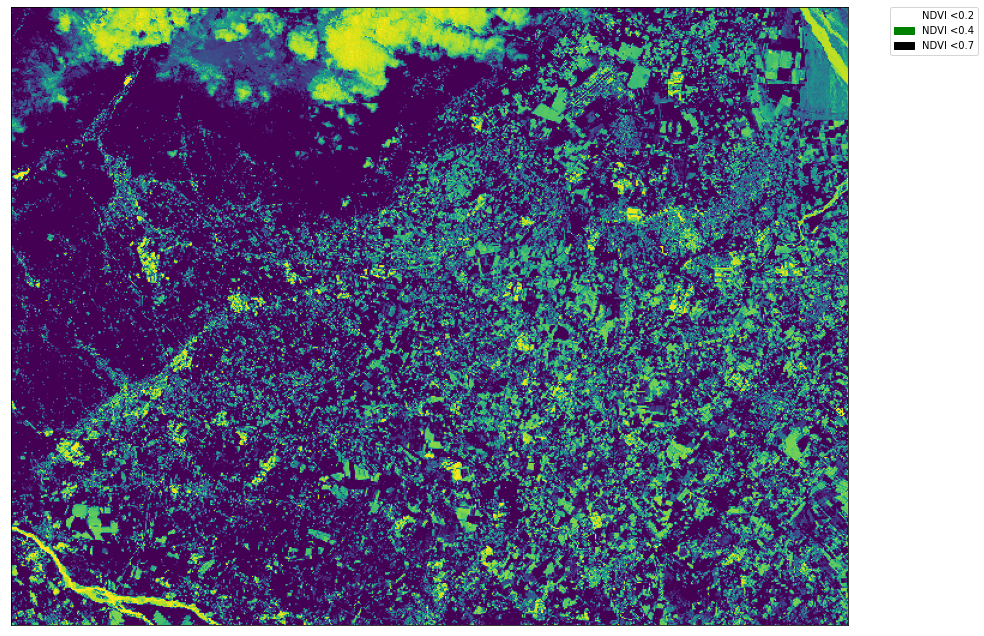

In [ ]:
## plot image

img_ndvi = request_ndvi.get_data()[0]
plot_image(img_ndvi, colors=ndvi_colors, index="NDVI", factor=3.5/255, clip_range=(0,1))


###4. SAVI

SAVI stands for Soil Adjusted Vegetation Index. It is similar to NDVI but used in an area where vegetative cover is lower than 40%.
Useful when analysing young crops, arid regions with sparse vegetation and exposed soil surfaces.


In [ ]:
## SAVI evalscript

evalscript_savi = '''
//VERSION=3
    function setup() {
      return{
        input: [{ bands: ["B04", "B08"] }],
        output: { id: "default", bands: 1, sampleType: SampleType.FLOAT32 }
      }
    }
    function evaluatePixel(sample) {
      let L = 0.428
	    let NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + L) * (1 +L)
      return colorBlend( NDVI, [0, 0.5, 1], [[1,1,1], [0, 0.5, 0],  [0, 0, 0]])
      
    }
'''

In [ ]:
## request cloud free SAVI

request_savi = SentinelHubRequest(
    evalscript=evalscript_savi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
            mosaicking_order="leastCC"
      )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=sacile_bbox,
    size=sacile_size,
    config=config
    )

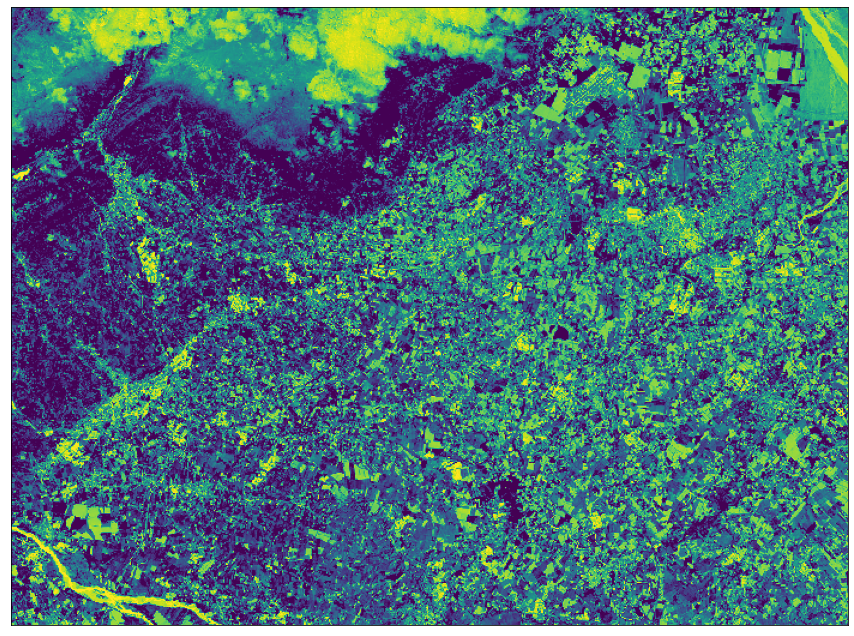

In [ ]:
## plot image

img_savi = request_savi.get_data()[0]
plot_image(img_savi, colors=None, index=None, factor=3.5/255, clip_range=(0,1))

##City area polygon

Passing coordinates data of my hometown administrative area 

In [ ]:
## Cities dataframe

try:
  df_cities = gpd.read_file("gadm36_ITA_3.shp")
  df_cities.columns
  
  
except Exception:
  print("no cities database charged")

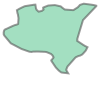

In [ ]:
## City polygon


the_city = "Sacile" 

city_data = df_cities[df_cities["NAME_3"] == the_city]
city_polygon = city_data['geometry']



# prepare geometry points to fit sentinel hub parameter, an array for each coordinates couple:
the_index = city_polygon.index[0]
city_polygon = city_polygon[the_index]
city_polygon

In [ ]:
## Parameters setup

polygon = city_polygon


## setting image borders and date
adm_geometry = Geometry(geometry=polygon, crs=CRS.WGS84)



##Examples - Administrative areas

Visualizing the previous indices on my hometown administrative area boundaries

###1. Cloud free true colors image

First available image in specified timespan of my hometown administrative area

In [ ]:
## True color evalscript

evalscript_true_color = """
    //VERSION=3
    function setup() {return {
            input: [{
              bands: ["B02", "B03", "B04"]
            }],
            output: {bands: 3}
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""


In [ ]:
## request first cloud free image

request_leastCC = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
            mosaicking_order="leastCC"
      )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    geometry=adm_geometry,
    config=config
)

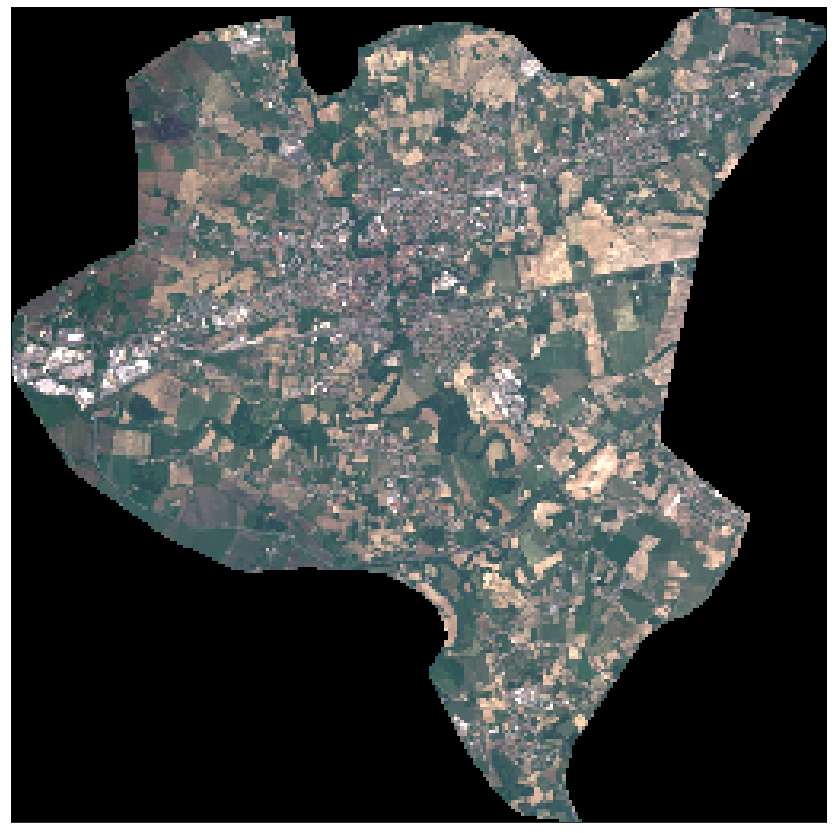

In [ ]:
## plot image

img_leastCC = request_leastCC.get_data()[0]
plot_image(img_leastCC, colors=None, index=None, factor=3.5/255, clip_range=(0,1))

###2. NDVI

NDVI, Normalized Difference Vegetation Index, it's commonly used to quantify green vegetation in a desired area. It represents the state of vegetation health based on how plants reflect light at certain wavelenghts. NDVI values range from -1 to 1, where:

- 0.2 to 0.4 represent grassland and shrub;
- 0.4 to 0.7 correspond to denser vegetation


In [ ]:
## NDVI evalscript

evalscript_ndvi = '''
//VERSION=3
function setup(){return{input: [{bands: ["B04", "B08" ]}], 
                        output: {id: "default", bands: 1,
                                  sampleType: SampleType.FLOAT32}}}

function evaluatePixel(sample) {
  var NDVI = (sample.B08 - sample.B04)/(sample.B08 + sample.B04) 
  return [NDVI]
  }
'''

# return colorBlend( NDVI, [0, 0.5, 1], [[1,1,1], [0, 0.5, 0],  [0, 0, 0]])

In [ ]:
## cloud free NDVI

request_ndvi = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
            mosaicking_order="leastCC"
      )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    geometry=adm_geometry,
    config=config
)

SACILE


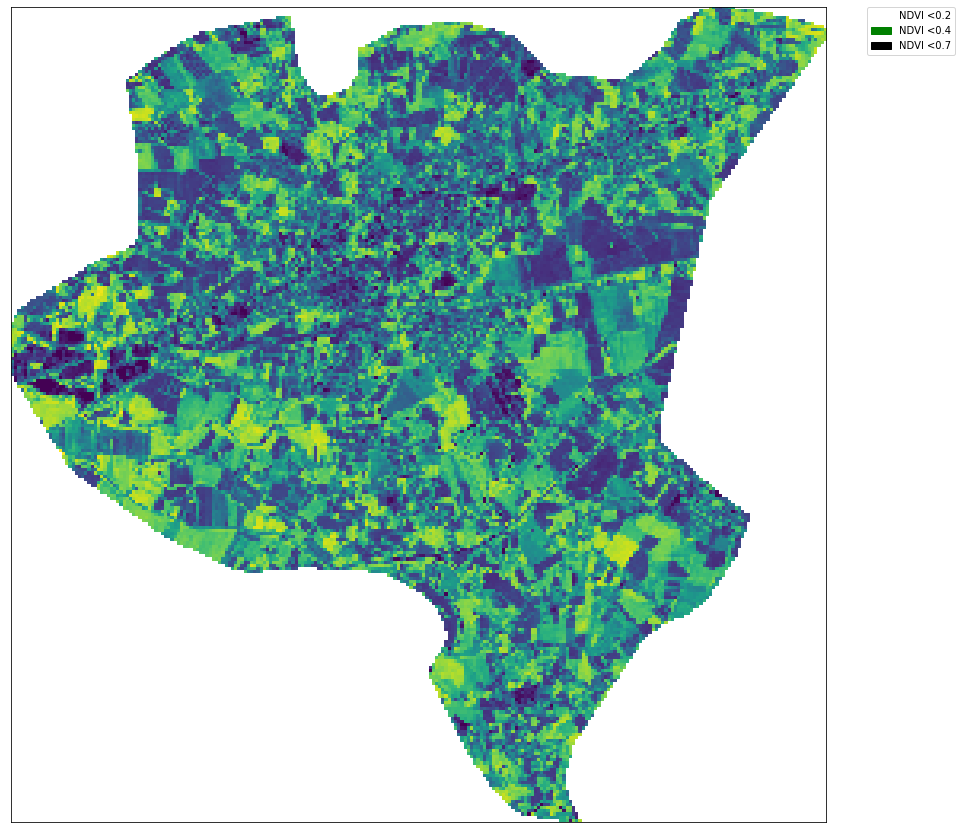

In [ ]:
## plot image

img_ndvi= request_ndvi.get_data()[0]
print(the_city.upper())
plot_image(img_ndvi, colors=ndvi_colors, index="NDVI", factor=3.5/255, clip_range=(0,1))

###3. SAVI

SAVI stands for Soil Adjusted Vegetation Index. It is similar to NDVI but used in an area where vegetative cover is lower than 40%.
Useful when analysing young crops, arid regions with sparse vegetation and exposed soil surfaces.


In [ ]:
## SAVI evalscript

evalscript_savi = '''
//VERSION=3
    function setup() {
      return{
        input: [{ bands: ["B04", "B08"] }],
        output: { id: "default", bands: 1, sampleType: SampleType.FLOAT32 }
      }
    }
    function evaluatePixel(sample) {
          let L = 0.428
	let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + L) * (1 +L)
      return [ ndvi ]
    }
'''

In [ ]:
## cloud free SAVI

request_savi = SentinelHubRequest(
    evalscript=evalscript_savi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=timespan,
            mosaicking_order="leastCC"
      )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    geometry=adm_geometry,
    config=config
)

SACILE


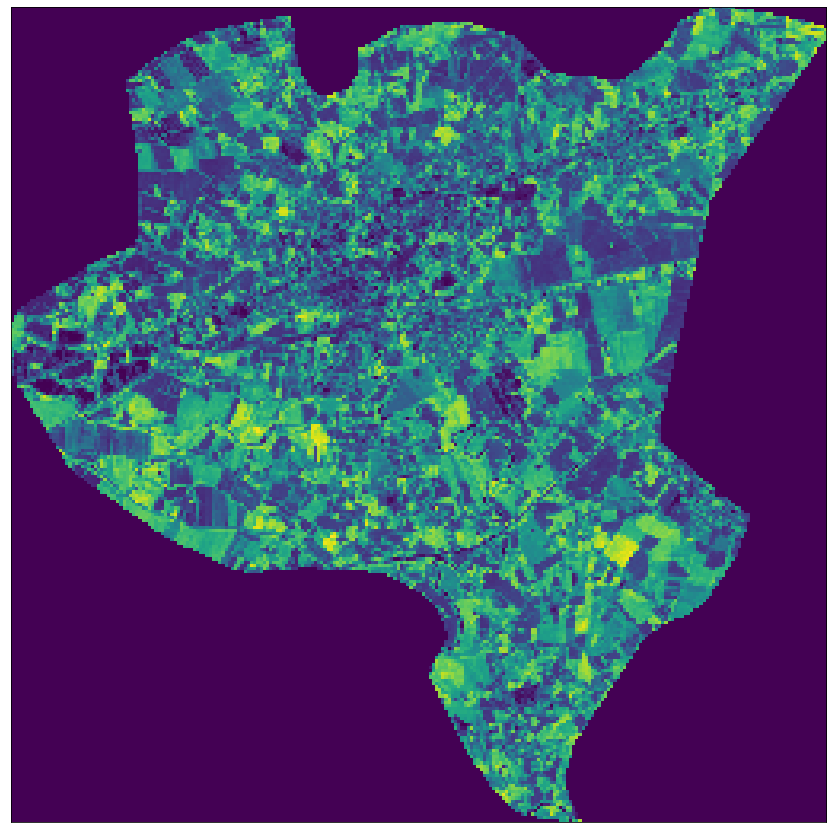

In [ ]:
## plot image

img_savi = request_savi.get_data()[0]
print(the_city.upper())
plot_image(img_savi, colors=None, index=None, factor=3.5/255, clip_range=(0,1))